In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Take from GABRIEL ATKIN Fish Image Species Classification

In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf 

import os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

In [22]:
image_dir = Path('/content/drive/MyDrive/india_aid_snake/Snake Images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [23]:
image_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous
1,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous
2,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous
3,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous
4,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous


In [24]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/india_aid_snake/Snake I...,Non Venomous
1,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous
2,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous
3,/content/drive/MyDrive/india_aid_snake/Snake I...,Non Venomous
4,/content/drive/MyDrive/india_aid_snake/Snake I...,Non Venomous


In [25]:
image_df.shape

(1944, 2)

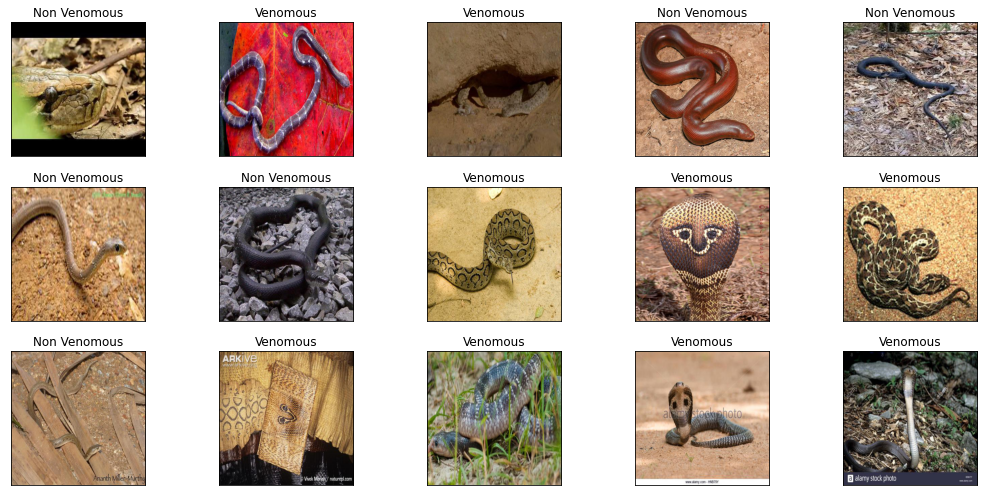

In [26]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [27]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [28]:
train_df.shape

(1749, 2)

In [29]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [30]:
train_df.head(5)

,Filepath,Label
1836,/content/drive/MyDrive/india_aid_snake/Snake I...,Non Venomous
1821,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous
1301,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous
1753,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous
8,/content/drive/MyDrive/india_aid_snake/Snake I...,Venomous


In [31]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1400 validated image filenames belonging to 2 classes.
Found 349 validated image filenames belonging to 2 classes.
Found 195 validated image filenames belonging to 2 classes.


In [32]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=2)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(2, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [33]:
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]

In [34]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)

In [35]:
checkpoint_path = 'models/EfficientNetB1/model_224.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [36]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
44/44 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.7629 - auc: 0.8481 
Epoch 1: val_loss improved from inf to 0.82097, saving model to models/EfficientNetB1/model_224.h5
44/44 [==============================] - 633s 14s/step - loss: 0.4774 - accuracy: 0.7629 - auc: 0.8481 - val_loss: 0.8210 - val_accuracy: 0.4040 - val_auc: 0.4207 - lr: 0.0010
Epoch 2/5
44/44 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9200 - auc: 0.9706 
Epoch 2: val_loss improved from 0.82097 to 0.72838, saving model to models/EfficientNetB1/model_224.h5
44/44 [==============================] - 608s 14s/step - loss: 0.2135 - accuracy: 0.9200 - auc: 0.9706 - val_loss: 0.7284 - val_accuracy: 0.4040 - val_auc: 0.4053 - lr: 0.0010
Epoch 3/5
44/44 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9443 - auc: 0.9812 
Epoch 3: val_loss did not improve from 0.72838
44/44 [==============================] - 604s 14s/step - loss: 0.1677 - acc

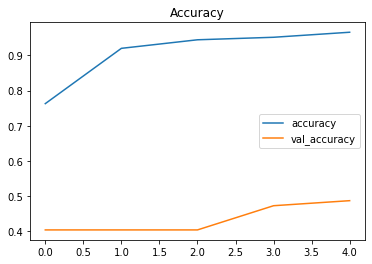

In [37]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [38]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.71598
Test Accuracy: 49.74%


In [39]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 19s 2s/step
The first 5 predictions: ['Venomous', 'Non Venomous', 'Venomous', 'Non Venomous', 'Non Venomous']


In [40]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

Non Venomous       0.41      0.61      0.49        77
    Venomous       0.62      0.42      0.51       118

    accuracy                           0.50       195
   macro avg       0.52      0.52      0.50       195
weighted avg       0.54      0.50      0.50       195



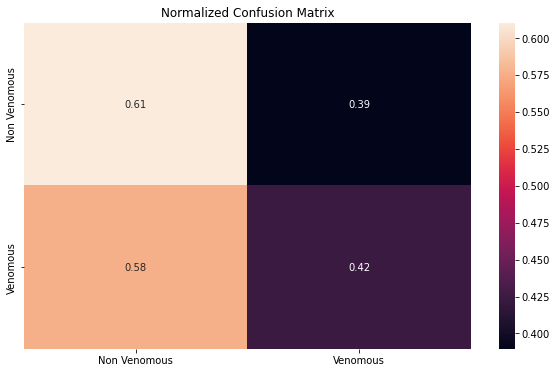

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

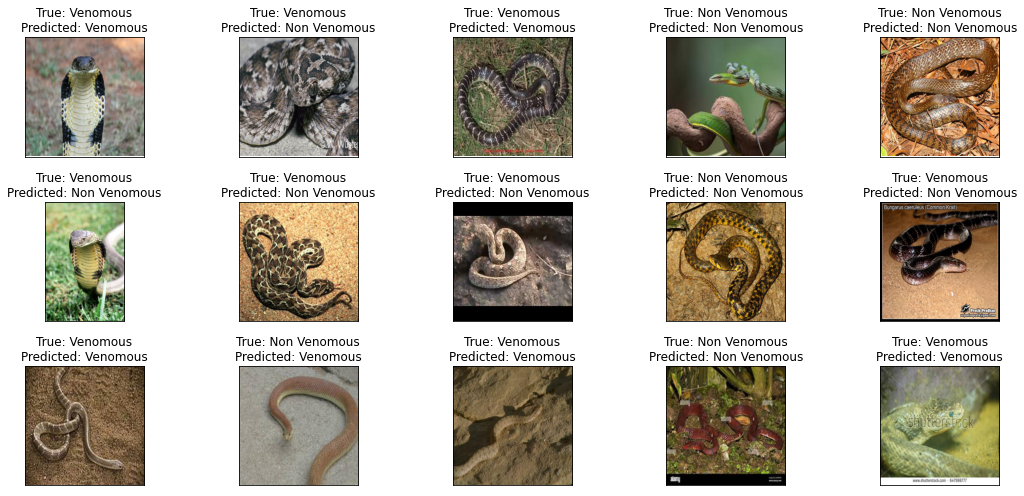

In [42]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [43]:
!pip install -U ipykernel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 4.0 MB/s 
     |████████████████████████████████| 423 kB 40.5 MB/s 
     |████████████████████████████████| 793 kB 47.3 MB/s 
     |████████████████████████████████| 1.6 MB 38.7 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 6.0.4
    Uninstalling tornado-6.0.4:
      Successfully uninstalled tornado-6.0.4
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.3.4
    Uninstalling ipykernel-5.3.4:
      Successfully uninstalled ipykernel-5.3.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 

In [44]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 4.2 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=fdaf36e19452b271d65b665876a298efa354b992be0b7b99256839053277f612
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [45]:
!pip install -q streamlit

     |████████████████████████████████| 9.2 MB 4.1 MB/s 
     |████████████████████████████████| 78 kB 4.5 MB/s 
     |████████████████████████████████| 182 kB 47.5 MB/s 
     |████████████████████████████████| 4.7 MB 35.1 MB/s 
     |████████████████████████████████| 237 kB 48.4 MB/s 
     |████████████████████████████████| 164 kB 42.7 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 51 kB 3.8 MB/s 
